<a href="https://colab.research.google.com/github/apriandito/nowcasting/blob/main/9_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting

**Tujuan**: Memprediksi nilai masa depan (1-3 periode ke depan)

**Methods**:
- Machine Learning Models
- Time Series Split Validation
- Explainable AI (SHAP)

## 1. Import Libraries

In [1]:
# Uncomment dan jalankan jika library belum terinstall
# !pip install shap plotly scikit-learn pandas numpy matplotlib prophet statsmodels

## 0. Install Required Libraries (if needed)

Jalankan cell di bawah jika ada library yang belum terinstall

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.graph_objects as go
import shap
import matplotlib.pyplot as plt

## 2. Load Data

In [5]:
# Load data
df = pd.read_csv('data_forecasting.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.set_index('Date')

print(f"Data shape: {df.shape}")
print(f"Periode: {df.index.min()} - {df.index.max()}")
df.head()

Data shape: (58, 8)
Periode: 2020-01-01 00:00:00 - 2024-10-01 00:00:00


,Sukuk_Yield,Islamic_Stock_Index,Mudharabah_Deposit_Rate,Musyarakah_Financing,Zakat_Collection,Inflation_Rate,Islamic_Banking_Asset,Gold_Price_IDR
Date,,,,,,,,
2020-01-01,6.35,586.4,4.61,124.8,2.2,2.63,456.4,763835
2020-02-01,6.37,604.8,4.57,122.3,2.5,2.33,453.2,771001
2020-03-01,6.39,612.4,4.57,134.5,3.4,3.34,461.6,775866
2020-04-01,6.41,615.9,4.59,129.5,3.1,3.21,462.4,796071
2020-05-01,6.40,608.0,4.77,128.1,2.8,2.88,462.0,786975


In [6]:
# Pilih target variable
TARGET = 'Sukuk_Yield'  # Ganti sesuai kebutuhan

print(f"Target Variable: {TARGET}")
print(f"\nAvailable columns:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i}. {col}")

Target Variable: Sukuk_Yield

Available columns:
  1. Sukuk_Yield
  2. Islamic_Stock_Index
  3. Mudharabah_Deposit_Rate
  4. Musyarakah_Financing
  5. Zakat_Collection
  6. Inflation_Rate
  7. Islamic_Banking_Asset
  8. Gold_Price_IDR


In [7]:
# Plot target variable
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df.index,
    y=df[TARGET],
    mode='lines+markers',
    name=TARGET
))
fig.update_layout(
    title=f'Time Series: {TARGET}',
    xaxis_title='Date',
    yaxis_title=TARGET,
    template='plotly_white',
    width=1200,
    height=500
)
fig.show()

### 3.1 Correlation Analysis

In [8]:
# Correlation dengan target variable
import plotly.figure_factory as ff

# Hitung correlation matrix
corr_matrix = df.corr()

# Sort berdasarkan korelasi dengan TARGET (absolute value)
target_corr = corr_matrix[TARGET].drop(TARGET)  # Drop self-correlation
target_corr_abs = target_corr.abs().sort_values(ascending=False)

# Ambil top 10 berdasarkan absolute correlation
top_10_features = target_corr_abs.head(10).index.tolist()
top_10_corr = target_corr[top_10_features].sort_values()  # Sort untuk visualisasi

print(f"Computed correlation for {len(df.columns)} features")
print(f"Top 10 features selected based on absolute correlation with {TARGET}")

Computed correlation for 8 features
Top 10 features selected based on absolute correlation with Sukuk_Yield


In [9]:
# Visualisasi correlation heatmap (Top 10 features)
# Subset correlation matrix untuk top 10 features
corr_subset = corr_matrix.loc[top_10_features + [TARGET], top_10_features + [TARGET]]

# Plotly heatmap
fig = ff.create_annotated_heatmap(
    z=corr_subset.values,
    x=corr_subset.columns.tolist(),
    y=corr_subset.columns.tolist(),
    annotation_text=np.round(corr_subset.values, 2),
    colorscale='RdBu',
    zmid=0,
    showscale=True
)

fig.update_layout(
    title=f'Correlation Matrix - Top 10 Features (by absolute correlation with {TARGET})',
    xaxis={'side': 'bottom'},
    width=900,
    height=800,
    font=dict(size=10)
)

# Rotate x-axis labels
fig.update_xaxes(tickangle=-45)

fig.show()

In [10]:
# Bar plot: Top 10 Correlation dengan target
fig = go.Figure()

# Color berdasarkan positive/negative
colors = ['green' if x > 0 else 'red' for x in top_10_corr.values]

fig.add_trace(go.Bar(
    y=top_10_corr.index,
    x=top_10_corr.values,
    orientation='h',
    marker=dict(color=colors),
    text=np.round(top_10_corr.values, 3),
    textposition='auto'
))

fig.update_layout(
    title=f'Top 10 Feature Correlation dengan {TARGET}',
    xaxis_title='Correlation Coefficient',
    yaxis_title='Features',
    template='plotly_white',
    width=900,
    height=600,
    showlegend=False
)

fig.show()

# Print top 10 correlations
print(f"\nTop 10 features dengan korelasi tertinggi terhadap {TARGET}:")
print("="*70)
for i, (feature, corr_value) in enumerate(top_10_corr.sort_values(key=abs, ascending=False).items(), 1):
    print(f"{i:2d}. {feature:25s} : {corr_value:+.4f}")
print("="*70)


Top 10 features dengan korelasi tertinggi terhadap Sukuk_Yield:
 1. Mudharabah_Deposit_Rate   : +0.9571
 2. Gold_Price_IDR            : +0.9552
 3. Islamic_Banking_Asset     : +0.9385
 4. Zakat_Collection          : +0.9348
 5. Islamic_Stock_Index       : +0.9338
 6. Musyarakah_Financing      : +0.9091
 7. Inflation_Rate            : +0.0085


## 4. Feature Engineering

In [11]:
# Buat salinan untuk feature engineering
df_feat = df.copy()

# Lag features untuk semua variabel (shift 1 untuk avoid data leakage)
for col in df.columns:
    df_feat[f'{col}_lag1'] = df_feat[col].shift(1)
    df_feat[f'{col}_lag3'] = df_feat[col].shift(3)

# Moving averages
for col in df.columns:
    df_feat[f'{col}_MA3'] = df_feat[col].shift(1).rolling(window=3).mean()
    df_feat[f'{col}_MA6'] = df_feat[col].shift(1).rolling(window=6).mean()

# Rate of change
for col in df.columns:
    df_feat[f'{col}_ROC'] = df_feat[col].shift(1).pct_change()

# Standard deviation (volatility)
for col in df.columns:
    df_feat[f'{col}_STD3'] = df_feat[col].shift(1).rolling(window=3).std()

# Momentum
for col in df.columns:
    df_feat[f'{col}_Momentum'] = df_feat[col].shift(1) - df_feat[col].shift(2)

print(f"Shape sebelum dropna: {df_feat.shape}")
print(f"Missing values: {df_feat.isnull().sum().sum()}")

# Hapus missing values
df_feat_clean = df_feat.dropna()

print(f"\nShape setelah dropna: {df_feat_clean.shape}")
df_feat_clean.head()

Shape sebelum dropna: (58, 64)
Missing values: 160

Shape setelah dropna: (52, 64)


,Sukuk_Yield,Islamic_Stock_Index,Mudharabah_Deposit_Rate,Musyarakah_Financing,Zakat_Collection,Inflation_Rate,Islamic_Banking_Asset,Gold_Price_IDR,Sukuk_Yield_lag1,Sukuk_Yield_lag3,...,Islamic_Banking_Asset_STD3,Gold_Price_IDR_STD3,Sukuk_Yield_Momentum,Islamic_Stock_Index_Momentum,Mudharabah_Deposit_Rate_Momentum,Musyarakah_Financing_Momentum,Zakat_Collection_Momentum,Inflation_Rate_Momentum,Islamic_Banking_Asset_Momentum,Gold_Price_IDR_Momentum
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,6.30,599.8,4.74,135.3,2.6,3.92,469.3,783650,6.38,6.41,...,1.514376,5036.795046,-0.02,8.8,-0.05,16.8,-0.3,0.82,2.8,799.0
2020-08-01,6.20,611.5,4.71,141.3,2.6,3.77,465.3,772189,6.30,6.40,...,3.682843,2187.136713,-0.08,-17.0,0.02,-9.6,0.1,0.22,4.5,-4124.0
2020-09-01,6.28,627.8,4.76,155.9,3.3,3.99,471.5,789675,6.20,6.38,...,2.466441,8075.210235,-0.10,11.7,-0.03,6.0,0.0,-0.15,-4.0,-11461.0
2020-10-01,6.28,635.9,4.58,146.1,3.4,3.81,474.7,781224,6.28,6.30,...,3.143247,8882.711129,0.08,16.3,0.05,14.6,0.7,0.22,6.2,17486.0
2020-11-01,6.34,635.7,4.97,145.4,3.0,3.73,481.8,806627,6.28,6.20,...,4.779121,8744.625225,0.00,8.1,-0.18,-9.8,0.1,-0.18,3.2,-8451.0


## 5. Prepare Data for ML Models

In [12]:
# Feature columns (exclude target dari engineered features)
# Ambil semua original columns sebagai base features
original_cols = list(df.columns)

# Ambil engineered features (yang bukan target)
feature_cols = [col for col in df_feat_clean.columns if col not in original_cols or col != TARGET]
# Pastikan TARGET tidak termasuk dalam features
feature_cols = [col for col in feature_cols if col != TARGET and not col.startswith(f'{TARGET}_lag') and not col.startswith(f'{TARGET}_MA') and not col.startswith(f'{TARGET}_ROC') and not col.startswith(f'{TARGET}_STD') and not col.startswith(f'{TARGET}_Momentum')]

X = df_feat_clean[feature_cols]
y = df_feat_clean[TARGET]

print(f"Training data:")
print(f"  Features: {len(feature_cols)}")
print(f"  Samples: {len(X)}")
print(f"\nFeature columns:")
for i, col in enumerate(feature_cols[:10], 1):
    print(f"  {i}. {col}")
if len(feature_cols) > 10:
    print(f"  ... and {len(feature_cols) - 10} more features")

Training data:
  Features: 56
  Samples: 52

Feature columns:
  1. Islamic_Stock_Index
  2. Mudharabah_Deposit_Rate
  3. Musyarakah_Financing
  4. Zakat_Collection
  5. Inflation_Rate
  6. Islamic_Banking_Asset
  7. Gold_Price_IDR
  8. Islamic_Stock_Index_lag1
  9. Islamic_Stock_Index_lag3
  10. Mudharabah_Deposit_Rate_lag1
  ... and 46 more features


## 6. Define Models

In [13]:
# Daftar model
models = {
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.01, max_iter=5000),
    'BayesianRidge': BayesianRidge(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

print("Models:")
for i, name in enumerate(models.keys(), 1):
    print(f"  {i}. {name}")

Models:
  1. ElasticNet
  2. LinearRegression
  3. Ridge
  4. Lasso
  5. BayesianRidge
  6. RandomForest
  7. GradientBoosting


## 7. Time Series Split Validation

In [14]:
# Time Series Split - mirip walk-forward tapi dengan multiple folds
tscv = TimeSeriesSplit(n_splits=5)

validation_results = []

print(f"Time Series Split Validation: {tscv.n_splits} folds\n")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    print(f"Fold {fold}: Train {len(train_idx)} samples, Test {len(test_idx)} samples")

    # Train all models untuk fold ini
    for test_i in range(len(test_idx)):
        actual_idx = test_idx[test_i]

        result = {
            'Date': y.index[actual_idx],
            'Actual': y.iloc[actual_idx]
        }

        # Predict dengan semua model
        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test.iloc[[test_i]])[0]
            result[f'{name}_Pred'] = y_pred
            result[f'{name}_AbsErr'] = abs(y_pred - y.iloc[actual_idx])

        validation_results.append(result)

# Simpan hasil ke DataFrame
val_df = pd.DataFrame(validation_results)

print(f"\nValidation complete: {len(val_df)} predictions")
val_df.head()

Time Series Split Validation: 5 folds

Fold 1: Train 12 samples, Test 8 samples
Fold 2: Train 20 samples, Test 8 samples
Fold 3: Train 28 samples, Test 8 samples
Fold 4: Train 36 samples, Test 8 samples
Fold 5: Train 44 samples, Test 8 samples

Validation complete: 40 predictions


,Date,Actual,ElasticNet_Pred,ElasticNet_AbsErr,LinearRegression_Pred,LinearRegression_AbsErr,Ridge_Pred,Ridge_AbsErr,Lasso_Pred,Lasso_AbsErr,BayesianRidge_Pred,BayesianRidge_AbsErr,RandomForest_Pred,RandomForest_AbsErr,GradientBoosting_Pred,GradientBoosting_AbsErr
0,2021-07-01,6.51,6.504173,0.005827,6.547092,0.037092,6.546991,0.036991,6.537225,0.027225,6.546703,0.036703,6.5740,0.0640,6.595546,0.085546
1,2021-08-01,6.43,6.485753,0.055753,6.546858,0.116858,6.546720,0.116720,6.545992,0.115992,6.546324,0.116324,6.5645,0.1345,6.534023,0.104023
2,2021-09-01,6.41,6.433987,0.023987,6.461512,0.051512,6.461470,0.051470,6.464428,0.054428,6.461348,0.051348,6.5797,0.1697,6.607657,0.197657
3,2021-10-01,6.49,6.500894,0.010894,6.557720,0.067720,6.557611,0.067611,6.566757,0.076757,6.557299,0.067299,6.5760,0.0860,6.559233,0.069233
4,2021-11-01,6.57,6.558343,0.011657,6.592544,0.022544,6.592460,0.022460,6.601723,0.031723,6.592219,0.022219,6.5938,0.0238,6.603985,0.033985


## 8. Model Evaluation

In [15]:
# Function untuk menghitung Directional Accuracy
def directional_accuracy(y_true, y_pred):
    """
    Menghitung persentase prediksi yang benar arahnya (naik/turun)
    """
    if len(y_true) < 2:
        return np.nan

    # Hitung perubahan actual dan predicted
    actual_direction = np.diff(y_true) > 0
    pred_direction = np.diff(y_pred) > 0

    # Hitung akurasi arah
    correct_direction = actual_direction == pred_direction
    da = np.mean(correct_direction) * 100

    return da

# Evaluasi akurasi model
metrics = []
for name in models.keys():
    y_true = val_df['Actual'].values
    y_pred = val_df[f'{name}_Pred'].values

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    da = directional_accuracy(y_true, y_pred)

    metrics.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2,
        'DA': da  # Directional Accuracy
    })

# Hasil evaluasi
results_df = pd.DataFrame(metrics)
results_df = results_df.sort_values('RMSE')
print("Model Performance Metrics:")
print("="*80)
results_df.round(4)

Model Performance Metrics:


,Model,MAE,RMSE,MAPE,R2,DA
3,Lasso,0.0753,0.0989,1.0790,0.8360,64.1026
0,ElasticNet,0.0829,0.1135,1.1905,0.7838,64.1026
5,RandomForest,0.1476,0.1854,2.1084,0.4236,41.0256
2,Ridge,0.1660,0.2091,2.3956,0.2667,66.6667
6,GradientBoosting,0.1741,0.2105,2.5119,0.2568,46.1538
4,BayesianRidge,0.1782,0.2556,2.5904,-0.0957,56.4103
1,LinearRegression,0.2240,0.2968,3.2318,-0.4769,66.6667


## 9. Visualisasi Prediksi (Interactive)

In [16]:
# Visualisasi prediksi semua model
predictions = {name: val_df[f'{name}_Pred'].values for name in models.keys()}
y_test = val_df['Actual']

# Plotly interactive graph
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=val_df['Date'],
    y=y_test,
    mode='lines+markers',
    name='Actual',
    line=dict(width=2, color='black'),
    visible=True
))

for i, (name, y_pred) in enumerate(predictions.items()):
    fig.add_trace(go.Scatter(
        x=val_df['Date'],
        y=y_pred,
        mode='lines+markers',
        name=f'Predicted - {name}',
        line=dict(width=2),
        visible=(i == 0)
    ))

dropdown_buttons = []
n_models = len(predictions)
for i, name in enumerate(predictions.keys()):
    visibility = [True] + [j == i for j in range(n_models)]
    dropdown_buttons.append(dict(
        label=name,
        method='update',
        args=[
            {'visible': visibility},
            {'title': f'{name} - {TARGET} Forecasting (Time Series Split)'}
        ]
    ))

fig.update_layout(
    title=f'{TARGET} Forecasting (Time Series Split Validation)',
    xaxis_title='Date',
    yaxis_title=TARGET,
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    width=1200,
    height=600,
    updatemenus=[dict(
        buttons=dropdown_buttons,
        direction="down",
        showactive=True,
        x=1.15,
        xanchor="left",
        y=1.15,
        yanchor="top"
    )]
)
fig.show()

## 10. Forecast Ke Depan

In [17]:
# Pilih model terbaik
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"RMSE: {results_df.iloc[0]['RMSE']:.4f}")
print(f"MAPE: {results_df.iloc[0]['MAPE']:.2f}%")
print(f"Directional Accuracy: {results_df.iloc[0]['DA']:.2f}%")

Best Model: Lasso
RMSE: 0.0989
MAPE: 1.08%
Directional Accuracy: 64.10%


In [18]:
def auto_forecast_all_models(df, df_feat_clean, X, y, models, results_df, TARGET, feature_cols,
                              forecast_periods=71, auto_detect=True):
    """
    Flexible forecasting function yang otomatis detect frequency dan adjust

    Parameters:
    -----------
    forecast_periods : int, default=71
        Jumlah periods ke depan yang mau diforecast
    auto_detect : bool, default=True
        Kalau True, otomatis detect apakah data daily/monthly/weekly
    """

    # Auto-detect frequency dari data
    if auto_detect:
        time_diffs = y.index.to_series().diff().dropna()
        median_diff = time_diffs.median()

        if median_diff <= pd.Timedelta(days=1.5):
            freq = 'D'
            freq_name = 'days'
            offset_func = lambda x: pd.DateOffset(days=x)
        elif median_diff <= pd.Timedelta(days=10):
            freq = 'W'
            freq_name = 'weeks'
            offset_func = lambda x: pd.DateOffset(weeks=x)
        else:
            freq = 'MS'
            freq_name = 'months'
            offset_func = lambda x: pd.DateOffset(months=x)

        print(f"📊 Auto-detected frequency: {freq} ({freq_name})")
        print(f"   Median time difference: {median_diff}")
    else:
        freq = 'D'
        freq_name = 'days'
        offset_func = lambda x: pd.DateOffset(days=x)

    # Generate forecast dates
    forecast_dates = pd.date_range(
        start=y.index[-1] + offset_func(1),
        periods=forecast_periods,
        freq=freq
    )
    forecast_all_models = {'Date': forecast_dates}

    print(f"\n🔮 Forecasting {forecast_periods} {freq_name} ahead with all models...")
    print(f"   Method: Recursive forecasting (predict → update features → predict again)")
    print(f"   Period: {forecast_dates[0].strftime('%Y-%m-%d')} to {forecast_dates[-1].strftime('%Y-%m-%d')}")
    print("="*80)

    # Loop through all models
    for name, model in models.items():
        model.fit(X, y)

        # Recursive forecasting
        forecasts = []
        df_temp = df_feat_clean.copy()

        for i in range(forecast_periods):
            # Get last row features
            last_row = df_temp.iloc[[-1]][feature_cols]

            # Predict
            pred = model.predict(last_row)[0]
            forecasts.append(pred)

            # Create new row dengan predicted value untuk update features
            new_date = df_temp.index[-1] + offset_func(1)
            new_row = df_temp.iloc[-1].copy()
            new_row.name = new_date
            new_row[TARGET] = pred

            # Update original features dengan trend sederhana (linear extrapolation)
            for col in df.columns:
                if col != TARGET:
                    # Simple linear extrapolation dari 3 observasi terakhir
                    last_3 = df_temp[col].iloc[-3:].values
                    if len(last_3) >= 2:
                        trend = last_3[-1] - last_3[-2]
                        new_row[col] = last_3[-1] + trend

            # Update engineered features
            for col in df.columns:
                if f'{col}_lag1' in df_temp.columns:
                    new_row[f'{col}_lag1'] = df_temp[col].iloc[-1]
                if f'{col}_lag3' in df_temp.columns:
                    new_row[f'{col}_lag3'] = df_temp[col].iloc[-3] if len(df_temp) >= 3 else df_temp[col].iloc[0]
                if f'{col}_MA3' in df_temp.columns:
                    new_row[f'{col}_MA3'] = df_temp[col].iloc[-3:].mean()
                if f'{col}_MA6' in df_temp.columns:
                    new_row[f'{col}_MA6'] = df_temp[col].iloc[-6:].mean() if len(df_temp) >= 6 else df_temp[col].mean()
                if f'{col}_ROC' in df_temp.columns:
                    if df_temp[col].iloc[-1] != 0:
                        new_row[f'{col}_ROC'] = (new_row[col] - df_temp[col].iloc[-1]) / df_temp[col].iloc[-1]
                    else:
                        new_row[f'{col}_ROC'] = 0
                if f'{col}_STD3' in df_temp.columns:
                    new_row[f'{col}_STD3'] = df_temp[col].iloc[-3:].std()
                if f'{col}_Momentum' in df_temp.columns:
                    new_row[f'{col}_Momentum'] = df_temp[col].iloc[-1] - df_temp[col].iloc[-2] if len(df_temp) >= 2 else 0

            # Append new row
            df_temp = pd.concat([df_temp, pd.DataFrame([new_row])])

        forecast_all_models[name] = forecasts
        print(f"   ✓ {name} completed")

    # Convert ke DataFrame
    forecast_df = pd.DataFrame(forecast_all_models)

    # Pilih best model
    best_model_name = results_df.iloc[0]['Model']

    return forecast_df, freq_name

# Otomatis detect frequency dan forecast 71 periods kedepan
forecast_df, freq_type = auto_forecast_all_models(
    df, df_feat_clean, X, y, models, results_df, TARGET, feature_cols,
    forecast_periods=360,  # 👈 Ubah angka ini aja!
    auto_detect=True       # 👈 True = auto detect, False = manual
)

forecast_df

📊 Auto-detected frequency: MS (months)
   Median time difference: 31 days 00:00:00

🔮 Forecasting 360 months ahead with all models...
   Method: Recursive forecasting (predict → update features → predict again)
   Period: 2024-11-01 to 2054-10-01
   ✓ ElasticNet completed
   ✓ LinearRegression completed
   ✓ Ridge completed
   ✓ Lasso completed
   ✓ BayesianRidge completed
   ✓ RandomForest completed
   ✓ GradientBoosting completed


,Date,ElasticNet,LinearRegression,Ridge,Lasso,BayesianRidge,RandomForest,GradientBoosting
0,2024-11-01,7.171650,7.141832,7.177613,7.151409,7.179798,7.1389,7.139535
1,2024-12-01,7.264216,6.349923,7.437600,7.275522,7.261558,7.2412,7.279897
2,2025-01-01,7.362386,5.502248,7.858941,7.415407,7.357229,7.2486,7.283033
3,2025-02-01,7.444428,4.805823,7.825512,7.424573,7.427917,7.2559,7.282808
4,2025-03-01,7.516948,4.393741,7.729805,7.411178,7.490517,7.2651,7.303282
...,...,...,...,...,...,...,...,...
355,2054-06-01,22.086344,-301.508924,-26.847653,-22.674884,19.037052,7.2477,7.299770
356,2054-07-01,22.127821,-302.378517,-26.946353,-22.760672,19.069919,7.2477,7.299770
357,2054-08-01,22.169299,-303.248110,-27.045053,-22.846459,19.102786,7.2477,7.299770
358,2054-09-01,22.210776,-304.117703,-27.143753,-22.932247,19.135654,7.2477,7.299565


In [19]:
# Visualisasi Historical + Forecast (Interactive dengan Dropdown)
fig = go.Figure()

# Historical data (always visible)
fig.add_trace(go.Scatter(
    x=y.index,
    y=y.values,
    mode='lines+markers',
    name='Historical',
    line=dict(width=2, color='black'),
    marker=dict(size=4),
    visible=True
))

# Forecast untuk setiap model
for i, name in enumerate(models.keys()):
    # Forecast line
    fig.add_trace(go.Scatter(
        x=forecast_df['Date'],
        y=forecast_df[name],
        mode='lines+markers',
        name=f'Forecast - {name}',
        line=dict(width=3, dash='dash'),
        marker=dict(size=6),
        visible=(i == 0)  # Hanya model pertama yang visible
    ))

# Dropdown buttons
dropdown_buttons = []
for i, name in enumerate(models.keys()):
    # Historical (index 0) always visible, forecast (index i+1)
    visibility = [True] + [j == i for j in range(len(models))]

    dropdown_buttons.append(dict(
        label=name,
        method='update',
        args=[
            {'visible': visibility},
            {'title': f'{TARGET} - Historical + Forecast ({name})'}
        ]
    ))

fig.update_layout(
    title=f'{TARGET} - Historical + 3-Month Forecast',
    xaxis_title='Date',
    yaxis_title=TARGET,
    template='plotly_white',
    width=1200,
    height=600,
    legend=dict(x=0.01, y=0.99),
    hovermode='x unified',
    updatemenus=[dict(
        buttons=dropdown_buttons,
        direction="down",
        showactive=True,
        x=1.15,
        xanchor="left",
        y=1.15,
        yanchor="top"
    )]
)

# Add vertical line untuk pemisah
fig.add_shape(
    type="line",
    x0=y.index[-1], x1=y.index[-1],
    y0=0, y1=1,
    yref="paper",
    line=dict(color="gray", width=2, dash="dash")
)

# Add annotation
fig.add_annotation(
    x=y.index[-1],
    y=1,
    yref="paper",
    text="Forecast Start",
    showarrow=False,
    yanchor="bottom",
    font=dict(color="gray", size=12)
)

fig.show()

## 11. SHAP Analysis (XAI)

In [20]:
# SHAP Explainer
# Pilih explainer berdasarkan jenis model
if best_model_name in ['ElasticNet', 'LinearRegression', 'Ridge', 'Lasso', 'BayesianRidge']:
    # Untuk linear models, gunakan LinearExplainer
    explainer = shap.LinearExplainer(best_model, X)
    shap_values = explainer.shap_values(X)
else:
    # Untuk tree-based models (RandomForest, GradientBoosting)
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X)

print(f"SHAP explainer created for {best_model_name}")
print(f"SHAP values shape: {shap_values.shape if hasattr(shap_values, 'shape') else 'N/A'}")

SHAP explainer created for Lasso
SHAP values shape: (52, 56)


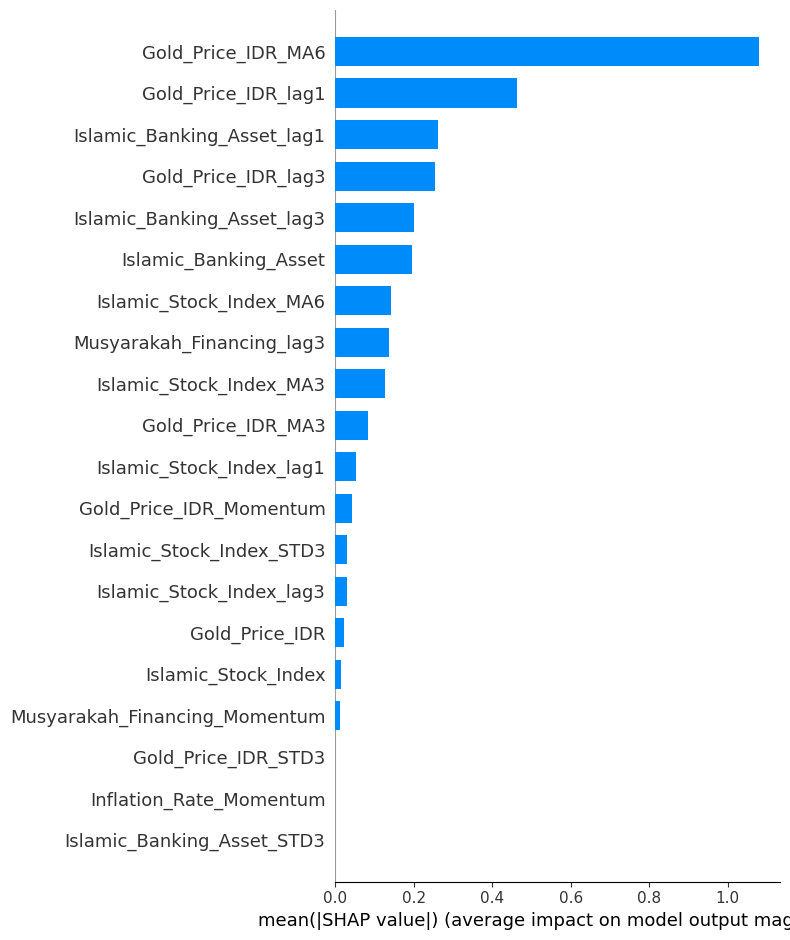

In [21]:
# Global feature importance
if best_model_name in ['ElasticNet', 'LinearRegression', 'Ridge', 'Lasso', 'BayesianRidge']:
    shap.summary_plot(shap_values, X, plot_type="bar")
else:
    shap.summary_plot(shap_values, plot_type="bar")

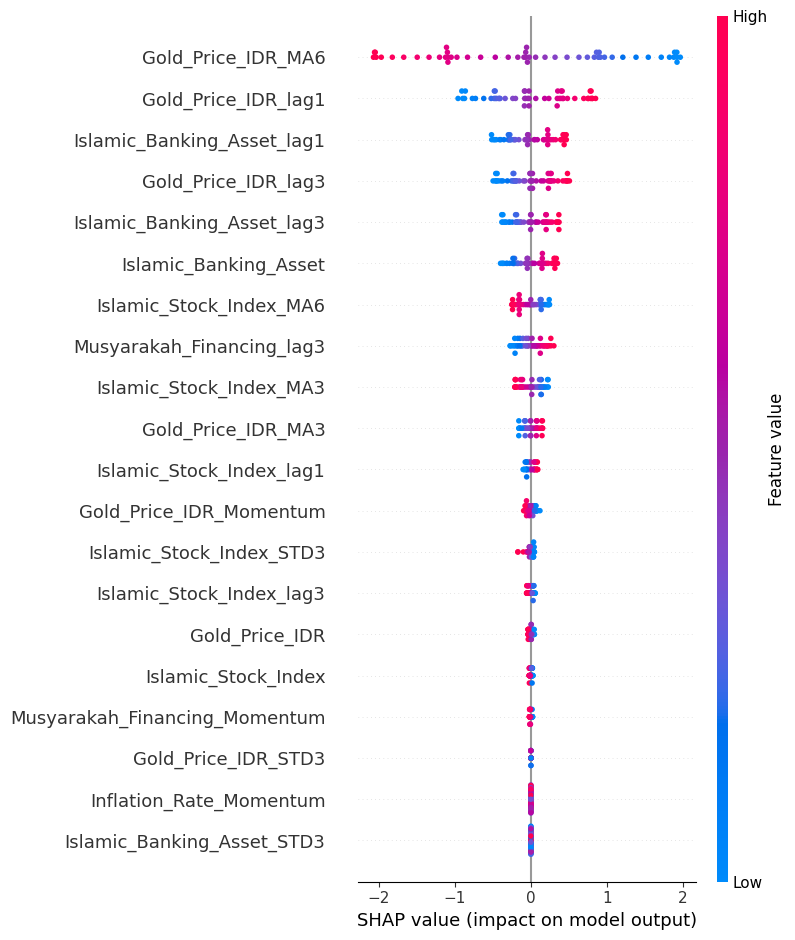

In [22]:
# SHAP beeswarm plot
if best_model_name in ['ElasticNet', 'LinearRegression', 'Ridge', 'Lasso', 'BayesianRidge']:
    shap.summary_plot(shap_values, X)
else:
    shap.summary_plot(shap_values)